## Part 3 of: "learning the Q-values with a neural network" ##

### shuffling the dataset at each optimization step ###

In [181]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In the previous "tutorial" we show that it's possible to learn the uderlying function that relates different arms of a non-linear bandit problem.

\\ 

In this notebook we will do the same, but now we add some "context" to each arm; and still there's a nonlinear function for the mean reward relating differnt arms 

In [182]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


In [183]:
def createdataset_l2(number_rews_per_beta_per_outcome_per_guess=10**2,number_of_betas = 10):
    #we call it l2 so it does not interfer with the fist tutoral..
    dataset = []
    labels=[]
    global betas_train
    global number_of_samples
    number_of_samples = number_rews_per_beta_per_outcome_per_guess
    betas_train = np.linspace(-1.5,1.5,number_of_betas)
    for i in range(len(betas_train)):
        beta = betas_train[i]
        for outcome in [0.,1.]:
            for guess in [-1.,1.]:

                for k in range(number_rews_per_beta_per_outcome_per_guess):
                    mean_bernoulli = qval(beta, outcome, guess)
                    reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]

                    dataset.append([beta, outcome, guess, reward])
    return np.array(dataset)

We can plot the data obtained, it's noisy!

Obviously, the more you sample the less noisy the average is!

## Now we want to train a network, defined below as Net1(), to learn this function over stochastic rewards, as we did in the case of a single $\beta$. The arquitecture we'll use is, as income, $(\beta, n, g)$ and as output $\hat{Q}(\beta, b ; g)$. ##

### Notice the difference in the input_shape=(3,) for self.l1 ##

In [184]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1, dropout=0.01):
        super(Net,self).__init__()
        self.dropout = dropout
        self.l1 = Dense(12, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(33, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(33, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(33, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.dropout(feat, rate=self.dropout)
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.dropout(feat, rate=self.dropout)
        feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.tanh(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


In [6]:
dataset = createdataset_l2(100,10)
dataset_copy = dataset.copy()


In [42]:
a = []
np.concatenate((a,[2.]))

array([2.])

In [71]:
optimizer = tf.keras.optimizers.SGD(lr=0.01)


In [74]:
optimizer.get_config()["name"]

'SGD'

In [185]:
def plot_results(histo_preds, mean_values, title=None):
    plt.figure(figsize=(15,15))
    ax1 =  plt.subplot2grid((1,2),(0,0))
    ax2 =  plt.subplot2grid((1,2),(0,1))

    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],'--',alpha=0.85,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],'--',alpha=0.85,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    
    for predictions in histo_preds.values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.5, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.5, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.5,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.5,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

        
    for ax in [ax1, ax2]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

In [186]:
def plot_loss(loss, title=None):
    plt.figure(figsize=(15,15))
    ax1 =  plt.subplot2grid((1,1),(0,0))

    ax1.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

    for ax in [ax1]:
        ax.set_xlabel("epoch", size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

## Let the experiments begin ##

Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 1.0
epochs: 30
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0: 



len(data[0]: 1)


Epoch 000: Loss: 0.2502556


Epoch 001: Loss: 0.2500425


Epoch 002: Loss: 0.2483958


Epoch 003: Loss: 0.2423247


Epoch 004: Loss: 0.2266788


Epoch 005: Loss: 0.2170213


Epoch 006: Loss: 0.2150481


Epoch 007: Loss: 0.2121127


Epoch 008: Loss: 0.2093269


Epoch 009: Loss: 0.2073439


Epoch 010: Loss: 0.2046734


Epoch 011: Loss: 0.2008336


Epoch 012: Loss: 0.2018875


Epoch 013: Loss: 0.2015172


Epoch 014: Loss: 0.1981069


Epoch 015: Loss: 0.1980945


Epoch 016: Loss: 0.1971996


Epoch 017: Loss: 0.1976820


Epoch 018: Loss: 0.1912349


Epoch 019: Loss: 0.1922072


Epoch 020: Loss: 0.1934510


Epoch 021: Loss: 0.1892579


Epoch 022: Loss: 0.1868569


Epoch 023: Loss: 0.1906343


Epoch 024: Loss: 0.1894331


Epoch 025: Loss: 0.1855097


Epoch 026: Loss: 0.1855768


Epoch 027: Loss: 0.1849657


Epoch 028: Loss: 0.1846680


Epoch 029: Loss: 0.1833246
Tardé:  0:01:41.736287


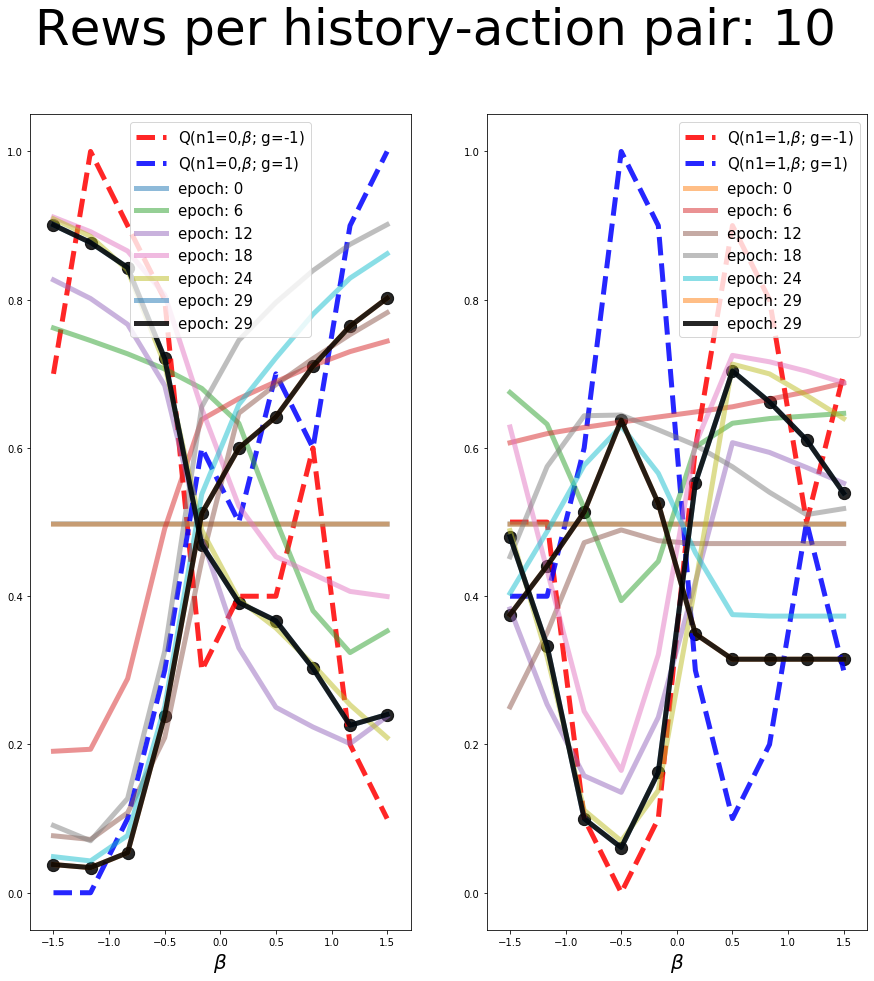

In [115]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=30, batch_size=1.,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0, dropout=0, optimizer="Adam", lr=10**-3) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

** comment **: this can change from run to run, but all converged

Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 5.0
epochs: 30
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0: 



len(data[0]: 5)


Epoch 000: Loss: 0.2502388


Epoch 001: Loss: 0.2502096


Epoch 002: Loss: 0.2501780


Epoch 003: Loss: 0.2501017


Epoch 004: Loss: 0.2500686


Epoch 005: Loss: 0.2500280


Epoch 006: Loss: 0.2501029


Epoch 007: Loss: 0.2501144


Epoch 008: Loss: 0.2500302


Epoch 009: Loss: 0.2500666


Epoch 010: Loss: 0.2500428


Epoch 011: Loss: 0.2501075


Epoch 012: Loss: 0.2500503


Epoch 013: Loss: 0.2500495


Epoch 014: Loss: 0.2499550


Epoch 015: Loss: 0.2500870


Epoch 016: Loss: 0.2500280


Epoch 017: Loss: 0.2498940


Epoch 018: Loss: 0.2499906


Epoch 019: Loss: 0.2498693


Epoch 020: Loss: 0.2495388


Epoch 021: Loss: 0.2495267


Epoch 022: Loss: 0.2487948


Epoch 023: Loss: 0.2479685


Epoch 024: Loss: 0.2475341


Epoch 025: Loss: 0.2501908


Epoch 026: Loss: 0.2480120


Epoch 027: Loss: 0.2483228


Epoch 028: Loss: 0.2466920


Epoch 029: Loss: 0.2476948
Tardé:  0:00:22.975298


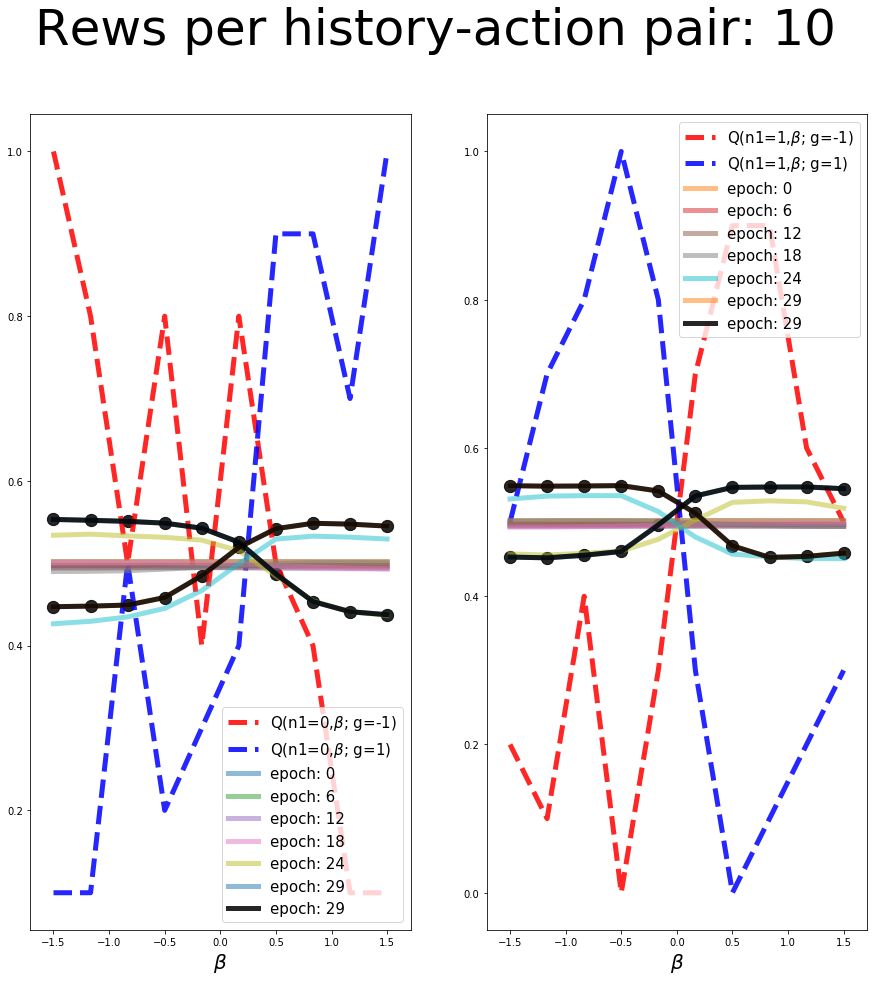

In [128]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=30, batch_size=5.,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0, dropout=0, optimizer="Adam", lr=10**-3) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

W0328 19:19:11.782966 140640683644736 legend.py:1282] No handles with labels found to put in legend.


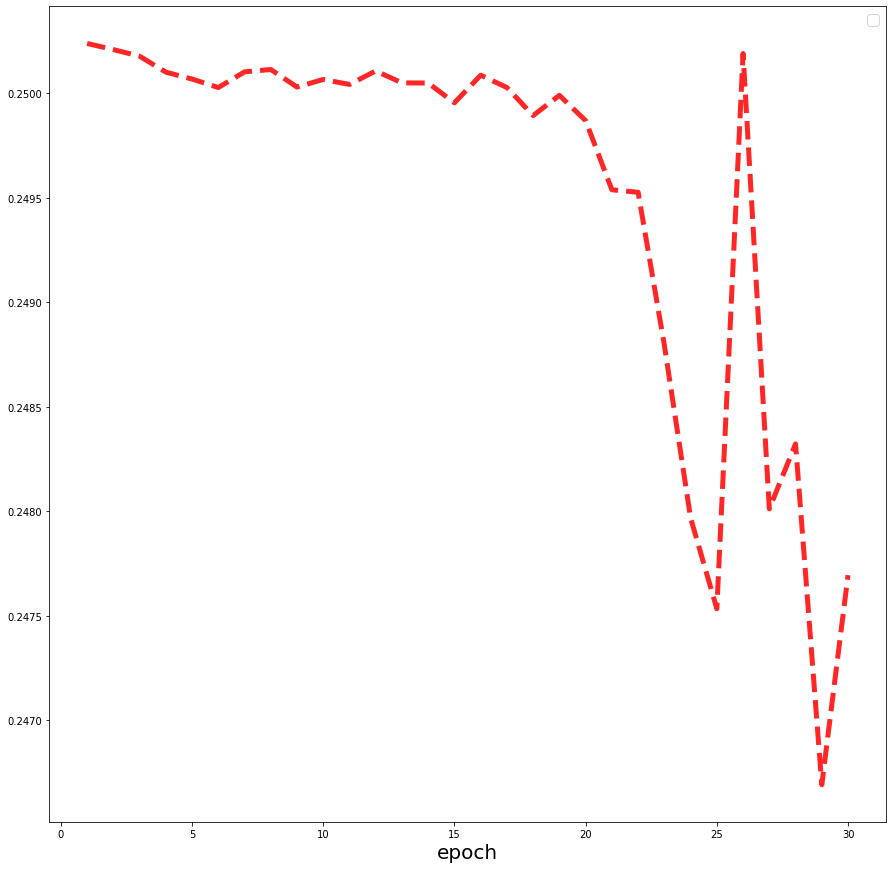

In [130]:
plot_loss(losses)

Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 4.0
epochs: 60
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0: 



len(data[0]: 4)


Epoch 000: Loss: 0.2506110


Epoch 006: Loss: 0.2503887


Epoch 012: Loss: 0.2498584


Epoch 018: Loss: 0.2491835


Epoch 024: Loss: 0.2475108


Epoch 030: Loss: 0.2470196


Epoch 036: Loss: 0.2478711


Epoch 042: Loss: 0.2478607


Epoch 048: Loss: 0.2467373


Epoch 054: Loss: 0.2460185


Tardé:  0:01:00.136088


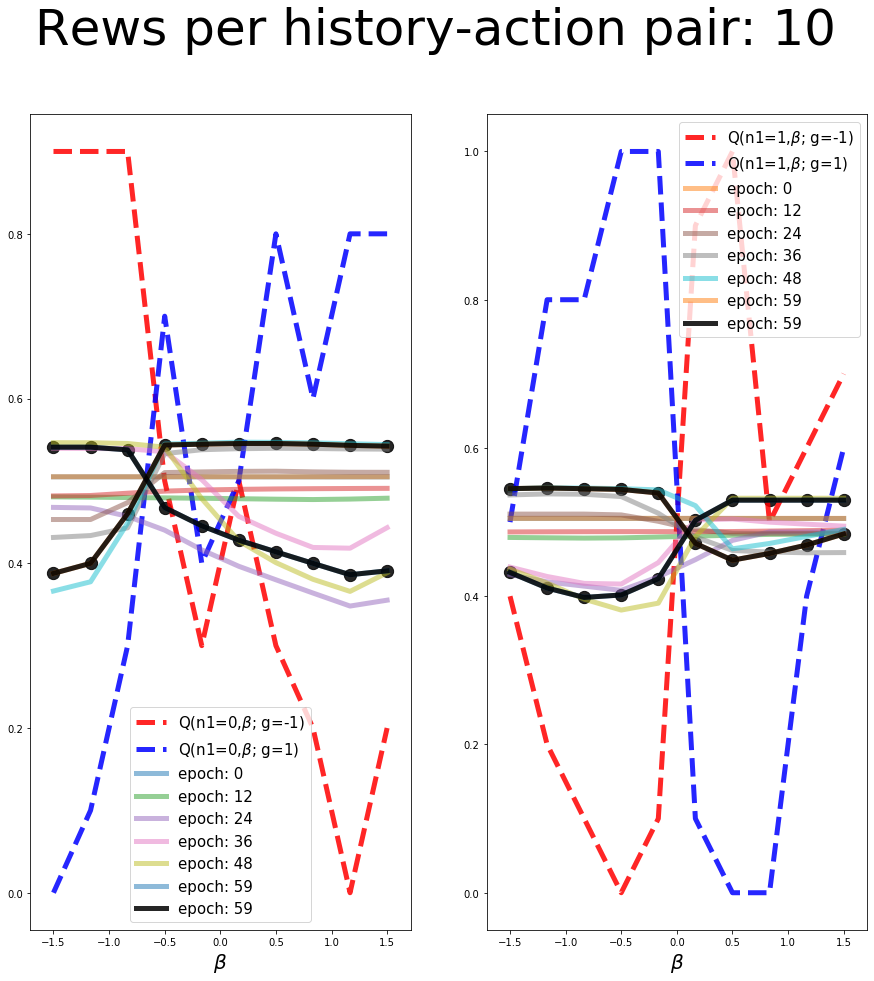

In [134]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=60, batch_size=4.,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0, dropout=0, optimizer_name="Adam", lr=10**-3, retraining=False) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

W0328 19:23:04.396090 140640683644736 legend.py:1282] No handles with labels found to put in legend.


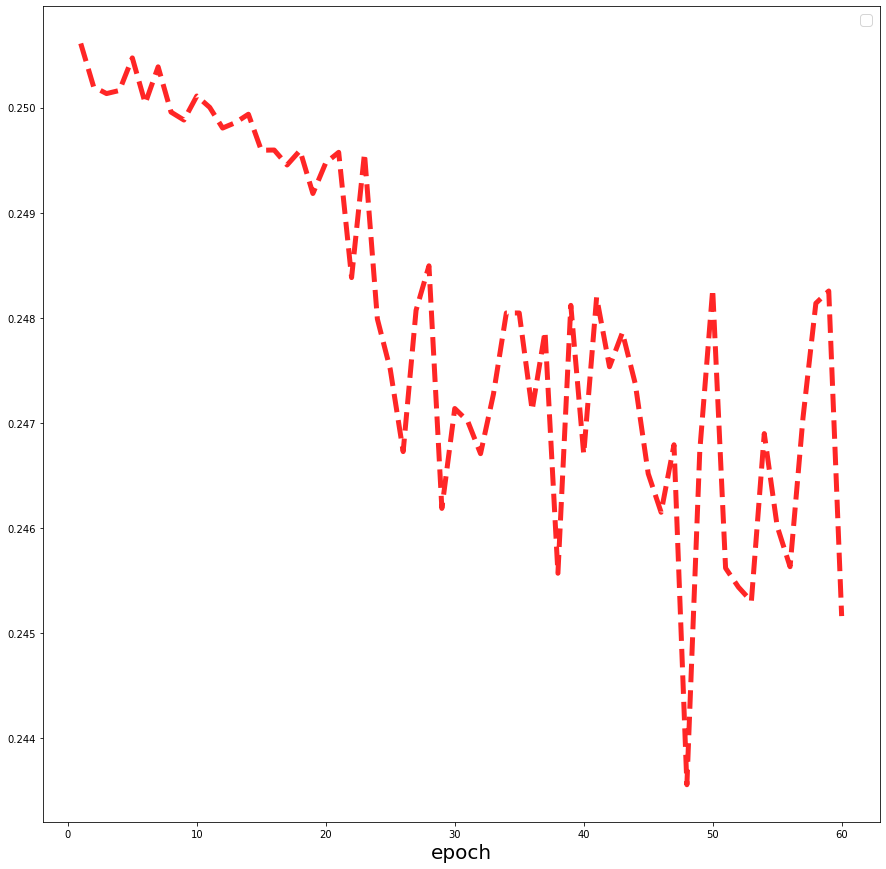

In [135]:
plot_loss(losses)

## veamos como es el valor de la loss che ##

In [187]:
def learning_problem(rews_per_beta, epochs=10, number_of_betas=10, lr=10**(-3), batch_size=2., seed_val = 0.1,shuffling_in_each_epoch= True,
                     valreg=0.01,dropout=0.01, optimizer_name="Adam", retraining=False, printing_losses=False, optimizer_object=None, net_object=None):
    start = datetime.now()
    dataset = createdataset_l2(rews_per_beta, number_of_betas=number_of_betas)
    dataset_copy = dataset.copy()
    
    splits = len(dataset)/batch_size
    batch_size_here = batch_size

    if not retraining:
        net = Net(seed_val=seed_val,valreg=valreg, dropout=dropout)
    
        if optimizer_name == "SGD":
            optimizer = tf.keras.optimizers.SGD(lr=lr)
        else:
            optimizer = tf.keras.optimizers.Adam(lr=lr)
    else:
        optimizer=optimizer_object
        net=net_object
        print("Re-training!!!!")
    
    print("Seed_val: {}\nOptimizer: {}\nReal number of splits (len(dataset) after spliting): {}\nlen(data[0]: {}\nBatch size: {}\nepochs: {}\nNumber_of_betas: {}\nrews_per_beta: {}\nNumber of data points: {}\nShuffling in each epoch\nRegularizer value: {}\nDropout rate (first and second layer): {}: ".format(
            seed_val,optimizer.get_config()["name"],len(dataset),len(dataset[0]),batch_size_here,epochs,number_of_betas,rews_per_beta,rews_per_beta*4*number_of_betas, shuffling_in_each_epoch, valreg,dropout)
         )
    print("")
    histo_preds = {} #here i save the predictions
    lossavg = []
    for epoch in tqdm(range(epochs)):
        epoch_loss_avg = tf.keras.metrics.Mean()

        if (shuffling_in_each_epoch == True)|(epoch==0):
            np.random.shuffle(dataset) #shuffling the dataset
            dataset = np.split(dataset, splits + len(dataset)%splits) #spliting the dataset!
        if epoch==0:
            print("len(data[0]: {})".format(len(dataset[0])))
        for indba,batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(batch[:,[0,1,2]]) #make predictions in batch
                rews = batch[:,3]
                loss_mean = tf.keras.losses.MSE(rews,preds)
                loss = tf.math.reduce_sum(loss_mean)/len(preds)

                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
            epoch_loss_avg(loss)
            if printing_losses:
                if indba%(len(dataset)/10)==0:
                    print("loss_mean: {}\nloss: {}\n\n".format(loss_mean,loss))
        lossavg.append(epoch_loss_avg.result())
            
        if epoch%(epochs/10)==0:
            print("Epoch {:03d}: Loss: {:.7f}".format(epoch,epoch_loss_avg.result()))

        ### concatenate the dataset again so we shuffle again #### 
        if shuffling_in_each_epoch == True:

            d = dataset[0]
            for k in range(1,len(dataset)):
                d = np.concatenate((d,dataset[k]))

            dataset = d

        if (epoch % int(epochs/5) == 0)|(epoch==epochs-1):

            histo_preds[str(epoch)] ={} 
            histo_preds[str(epoch)]["epoch_number"] = epoch
            histo_preds[str(epoch)]["values"] = {}

            index=0
            for n1 in [0.,1.]:
                for guess in [-1.,1.]:
                    foo =np.array([[b,n1,guess] for b in betas_train]) #betas_train defined as global in create_dataset_l2()
                    histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                    index+=1
    
    
    dataavg = np.split(dataset_copy, len(betas_train))

    mean_values = {}
    for index_beta in range(len(betas_train)):
        mean_values[str(index_beta)] = {}

    for index_beta, beta in enumerate(betas_train):
        sp = np.split(dataavg[index_beta],4)
        for index_ng in range(4):
            mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

    print("Tardé: ", datetime.now()-start)
    return histo_preds, mean_values, net, optimizer, lossavg
    
    
#in this case the length is 500*4*30, 4 'cause the n1 and guess, 30 'cause the len(betas_train)

Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 1.0
epochs: 10
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0: 



len(data[0]: 1)
loss_mean: [0.27341435]
loss: 0.2734143490480763


loss_mean: [0.26430047]
loss: 0.2643004698391044


loss_mean: [0.25438617]
loss: 0.25438616726185687


loss_mean: [0.24550032]
loss: 0.24550032440525613


loss_mean: [0.24926932]
loss: 0.2492693218475505


loss_mean: [0.24899077]
loss: 0.24899076771298784


loss_mean: [0.24484011]
loss: 0.2448401097940836


loss_mean: [0.24598671]
loss: 0.2459867089368114


loss_mean: [0.25371701]
loss: 0.2537170092554132


loss_mean: [0.24931686]
loss: 0.24931686263867336


Epoch 000: Loss: 0.2509002
loss_mean: [0.242757]
loss: 0.24275699652486005


loss_mean: [0.25995794]
loss: 0.2599579397677531


loss_mean: [0.22903099]
loss: 0.22903099421261766


loss_mean: [0.209269]
loss: 0.2092689994060874


loss_mean: [0.26897133]
loss: 0.26897132716497996


loss_mean: [0.21759603]
loss: 0.2175960303615619


loss_mean: [0.28409481]
loss: 0.2840948114901845


loss_mean: [0.2314744]
loss: 0.23147440193541752


loss_mean: [0.27759411]
loss: 0.2775

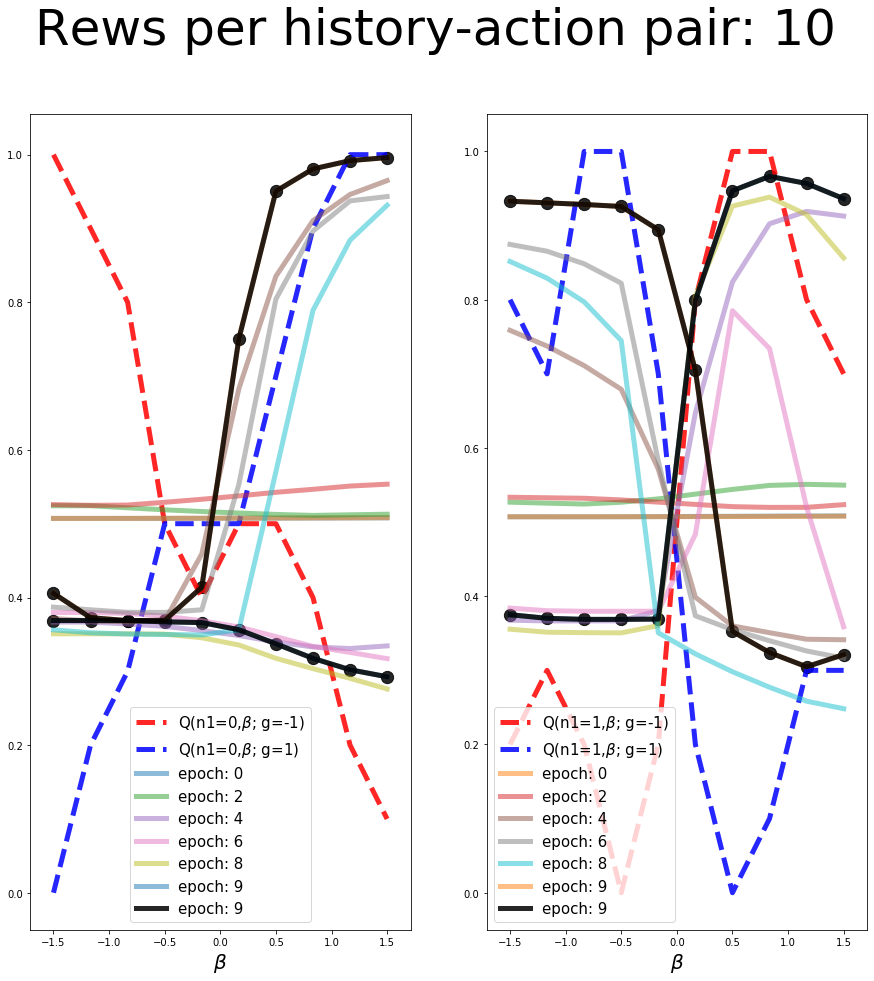

In [153]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10, batch_size=1.,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0, dropout=0, optimizer_name="Adam", lr=10**-3, retraining=False) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

W0328 19:41:43.628714 140640683644736 legend.py:1282] No handles with labels found to put in legend.


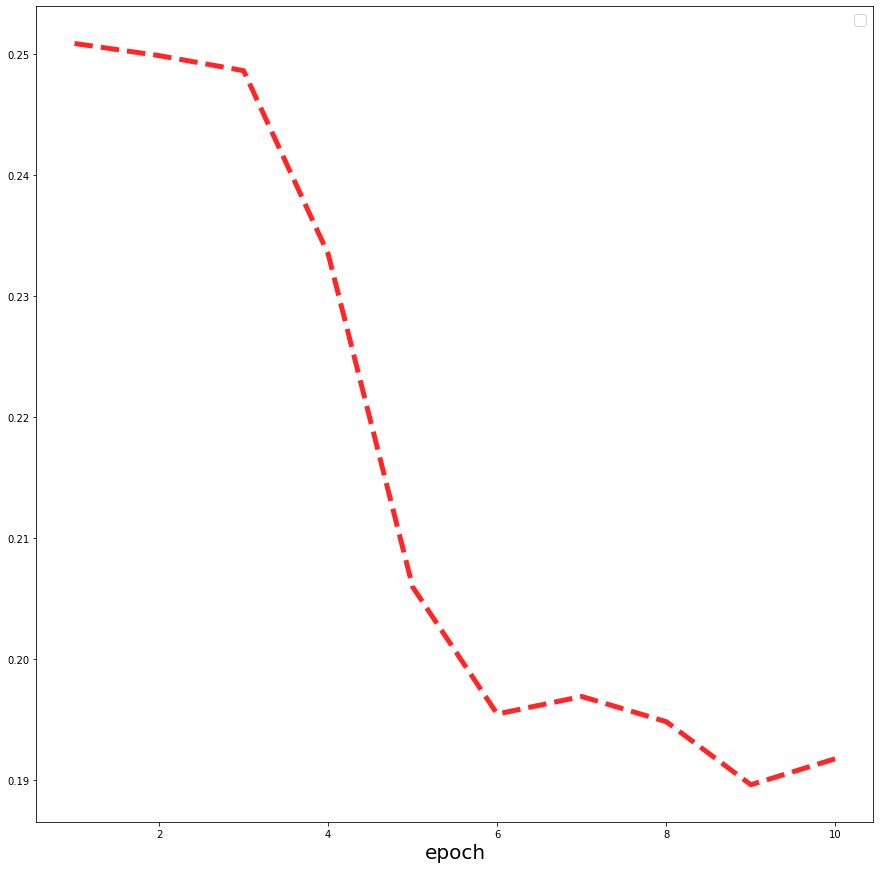

In [155]:
plot_loss(losses)

In [ ]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10, batch_size=2.,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-3, retraining=False,printing_losses=True
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 10.0
epochs: 2000
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 10)
Epoch 000: Loss: 0.2510114
Epoch 200: Loss: 0.2481269
Epoch 400: Loss: 0.2480367
Epoch 600: Loss: 0.2480256
Epoch 800: Loss: 0.2476818
Epoch 1000: Loss: 0.2475438
Epoch 1200: Loss: 0.2481042
Epoch 1400: Loss: 0.2478670
Epoch 1600: Loss: 0.2480902
Epoch 1800: Loss: 0.2482499
Tardé:  0:13:25.723525


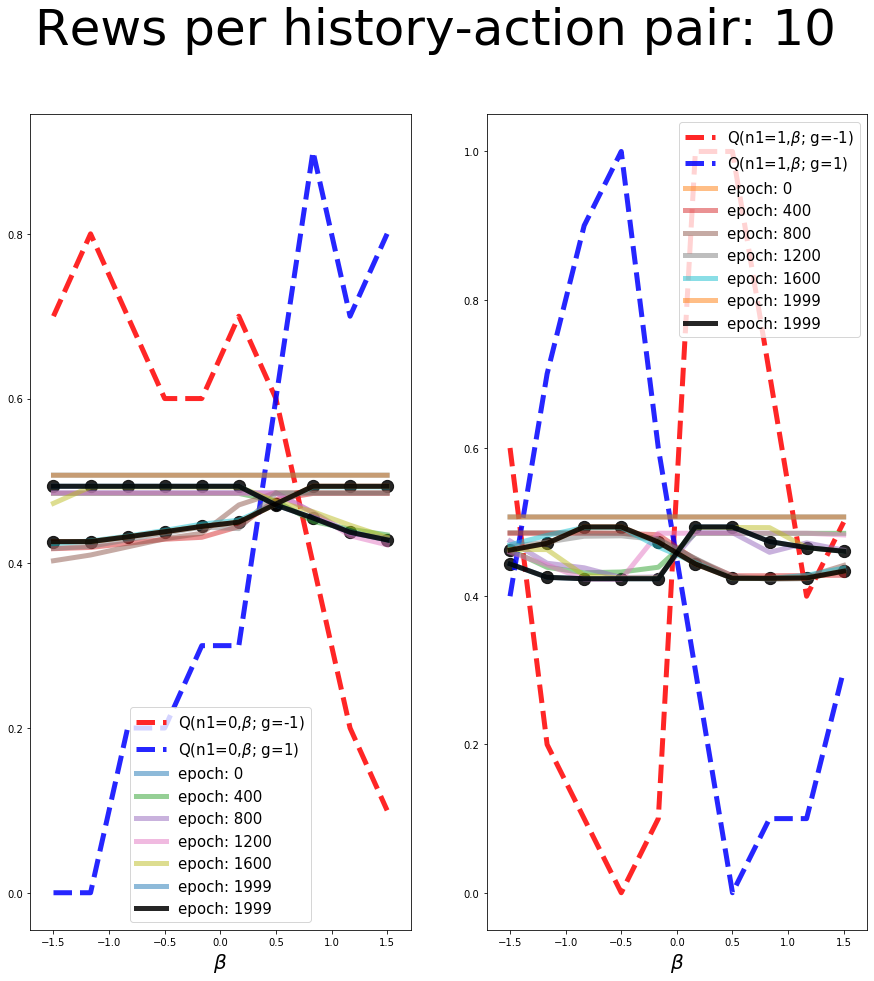

In [161]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=2000, batch_size=10.,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-3, retraining=False,printing_losses=False
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 10.0
epochs: 2000
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 10)
Epoch 000: Loss: 0.2501000
Epoch 200: Loss: 0.2497508
Epoch 400: Loss: 0.2496204
Epoch 600: Loss: 0.2497570
Epoch 800: Loss: 0.2495273
Epoch 1000: Loss: 0.2493217
Epoch 1200: Loss: 0.2477399
Epoch 1400: Loss: 0.2488475
Epoch 1600: Loss: 0.2483589
Epoch 1800: Loss: 0.2489021
Tardé:  0:13:07.534304


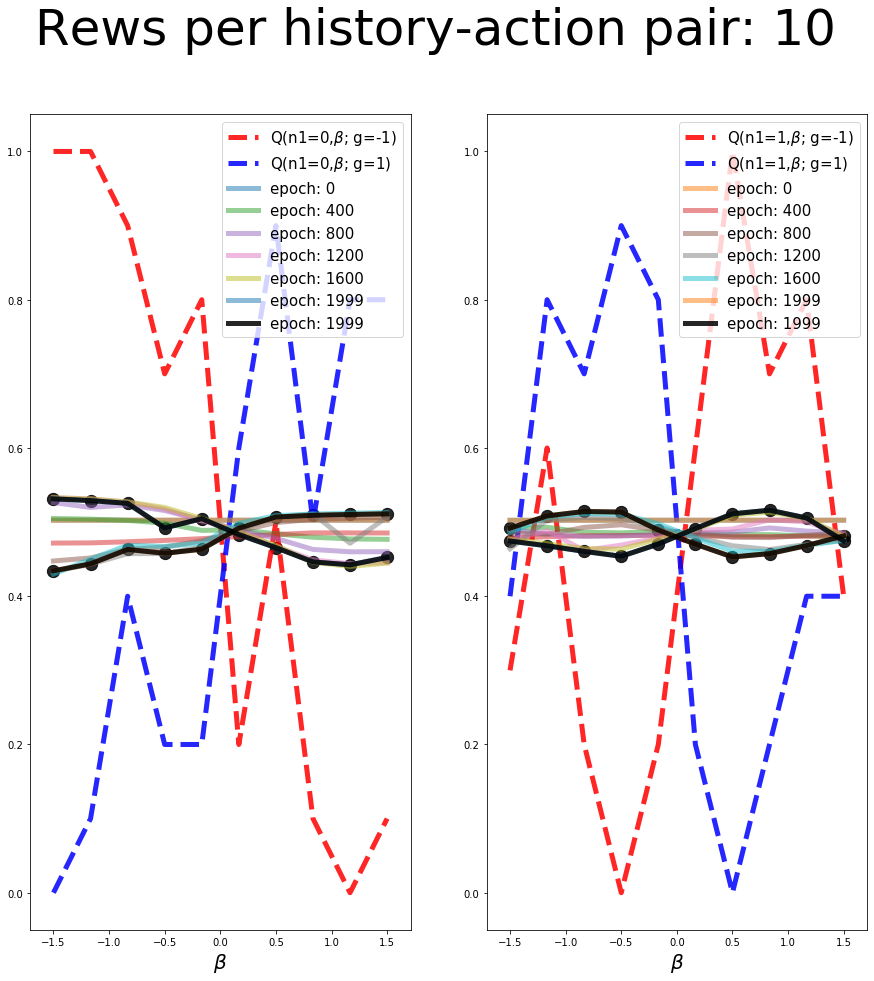

In [162]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=2000, batch_size=10.,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-4, retraining=False,printing_losses=False
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

## So, it seems it captures the feature but it can't copy the function. What i suspect is that it may lack initial values of the parameters ! LEt's see!

Seed_val: 1
Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 10.0
epochs: 200
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 10)
Epoch 000: Loss: 0.4887266
Epoch 020: Loss: 0.4518418
Epoch 040: Loss: 0.4117101
Epoch 060: Loss: 0.4001922
Epoch 080: Loss: 0.3822154
Epoch 100: Loss: 0.3778639
Epoch 120: Loss: 0.3690785
Epoch 140: Loss: 0.3603166
Epoch 160: Loss: 0.3635909
Epoch 180: Loss: 0.3634475
Tardé:  0:01:22.922941


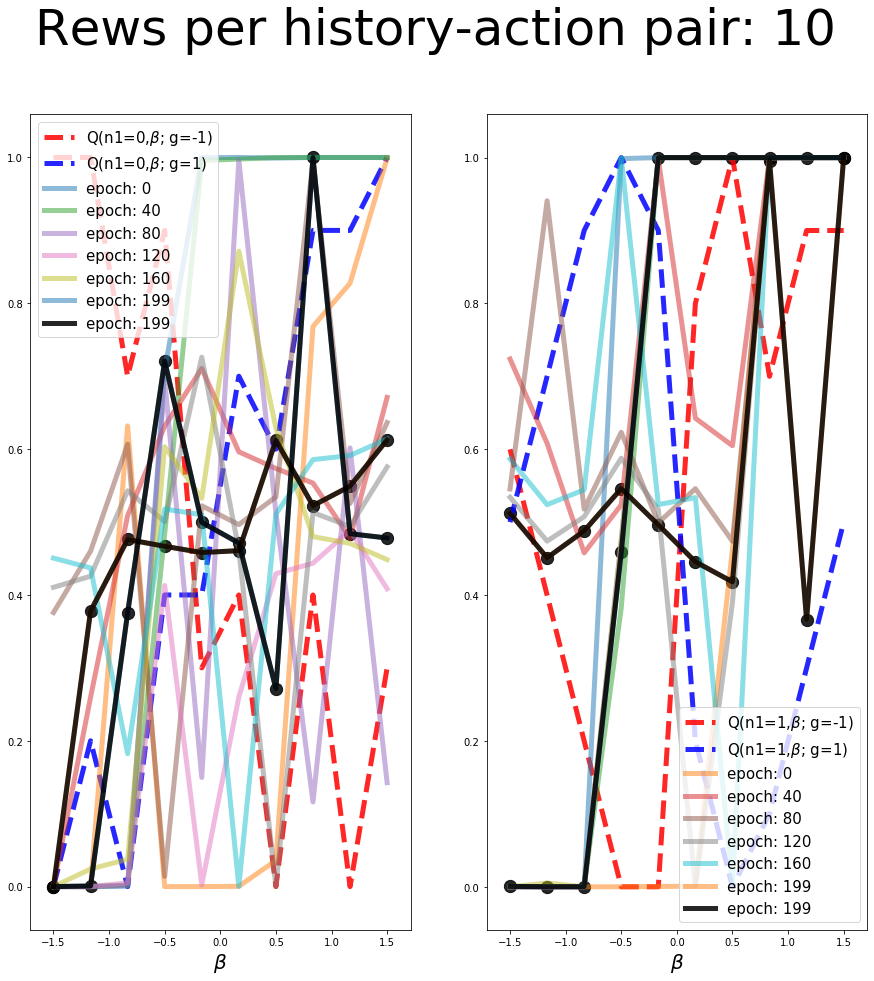

In [164]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=200, batch_size=10.,seed_val=1,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-4, retraining=False,printing_losses=False
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

Seed_val: 0.01
Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 1.0
epochs: 10
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 1)
Epoch 000: Loss: 0.2953324
Epoch 001: Loss: 0.2521435
Epoch 002: Loss: 0.2478677
Epoch 003: Loss: 0.2534150
Epoch 004: Loss: 0.2486044
Epoch 005: Loss: 0.2479545
Epoch 006: Loss: 0.2487624
Epoch 007: Loss: 0.2463775
Epoch 008: Loss: 0.2466251
Epoch 009: Loss: 0.2457966
Tardé:  0:00:39.477927


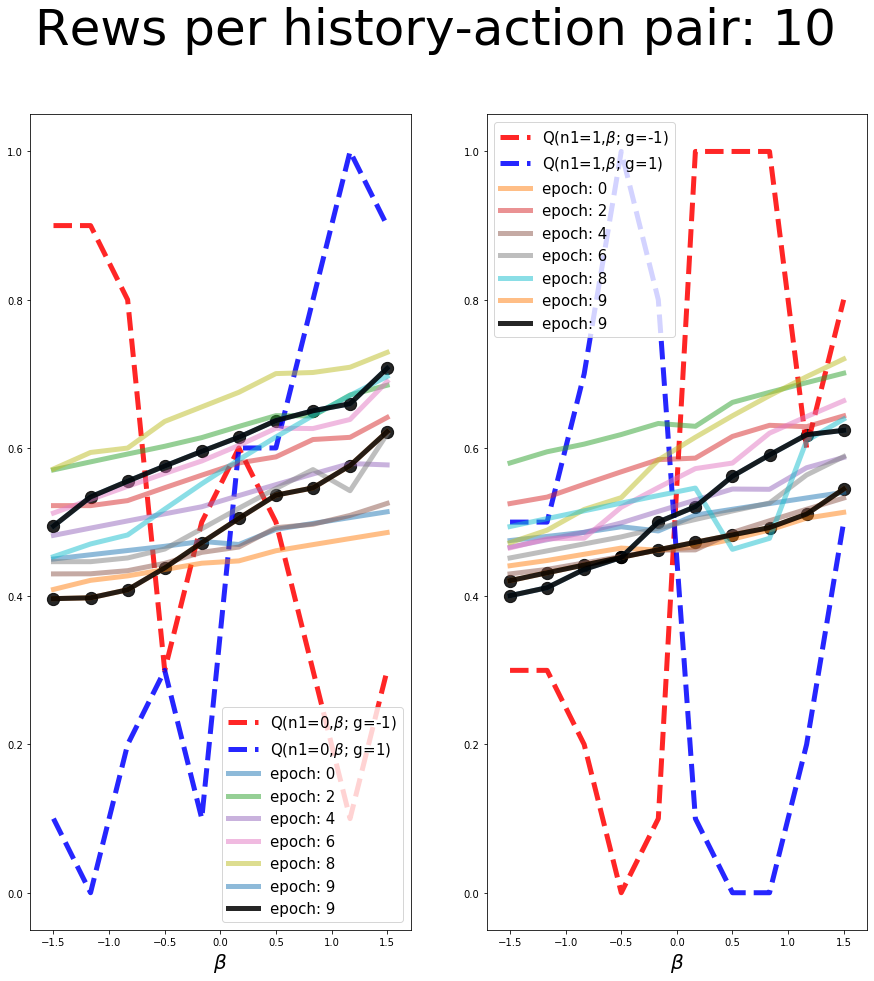

In [175]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10, batch_size=1.,seed_val=0.01,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-3, retraining=False,printing_losses=False,
                                                                    optimizer_object=optimizer,net_object=net
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

In [188]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1, dropout=0.01):
        super(Net,self).__init__()
        self.dropout = dropout
        self.l1 = Dense(120, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(330, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(330, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(33, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.dropout(feat, rate=self.dropout)
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.dropout(feat, rate=self.dropout)
        feat = tf.nn.relu(self.l3(feat))
        #feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


Seed_val: 0.01
Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 1.0
epochs: 10
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 1)
Epoch 000: Loss: 0.2501957
Epoch 001: Loss: 0.2500622
Epoch 002: Loss: 0.2500396
Epoch 003: Loss: 0.2484954
Epoch 004: Loss: 0.2323543
Epoch 005: Loss: 0.2073677
Epoch 006: Loss: 0.1789851
Epoch 007: Loss: 0.1694360
Epoch 008: Loss: 0.1585203
Epoch 009: Loss: 0.1509891
Tardé:  0:00:43.658530


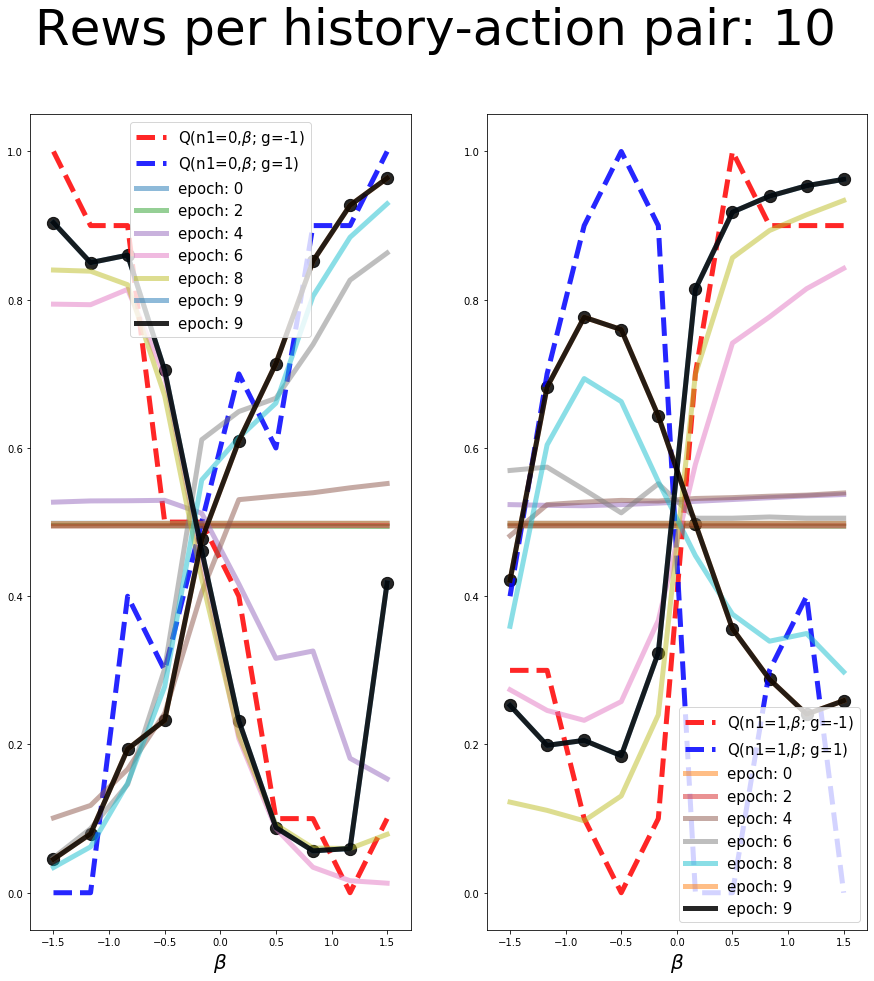

In [177]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10, batch_size=1.,seed_val=0.01,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-3, retraining=False,printing_losses=False,
                                                                    optimizer_object=optimizer,net_object=net
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

Re-training!!!!
Seed_val: 0.01
Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 1.0
epochs: 10
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 1)
Epoch 000: Loss: 0.1918440
Epoch 001: Loss: 0.1857316
Epoch 002: Loss: 0.1865116
Epoch 003: Loss: 0.1827194
Epoch 004: Loss: 0.1852780
Epoch 005: Loss: 0.1793866
Epoch 006: Loss: 0.1788473
Epoch 007: Loss: 0.1782837
Epoch 008: Loss: 0.1765589
Epoch 009: Loss: 0.1769650
Tardé:  0:00:41.109711


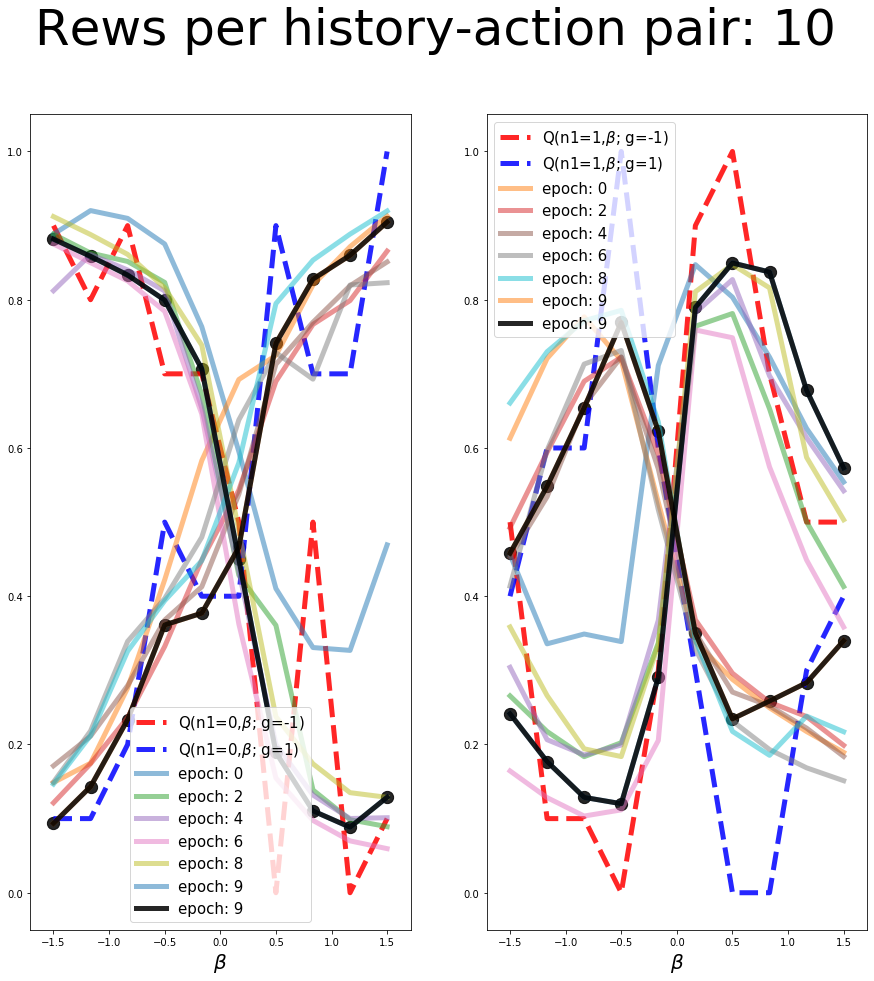

In [178]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10, batch_size=1.,seed_val=0.01,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-4, retraining=True,printing_losses=False,
                                                                    optimizer_object=optimizer,net_object=net
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

Re-training!!!!
Seed_val: 0.01
Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 1.0
epochs: 10
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 1)
Epoch 000: Loss: 0.1747298
Epoch 001: Loss: 0.1696111
Epoch 002: Loss: 0.1696838
Epoch 003: Loss: 0.1676189
Epoch 004: Loss: 0.1691894
Epoch 005: Loss: 0.1697705
Epoch 006: Loss: 0.1693742
Epoch 007: Loss: 0.1667050
Epoch 008: Loss: 0.1666830
Epoch 009: Loss: 0.1672992
Tardé:  0:00:41.047548


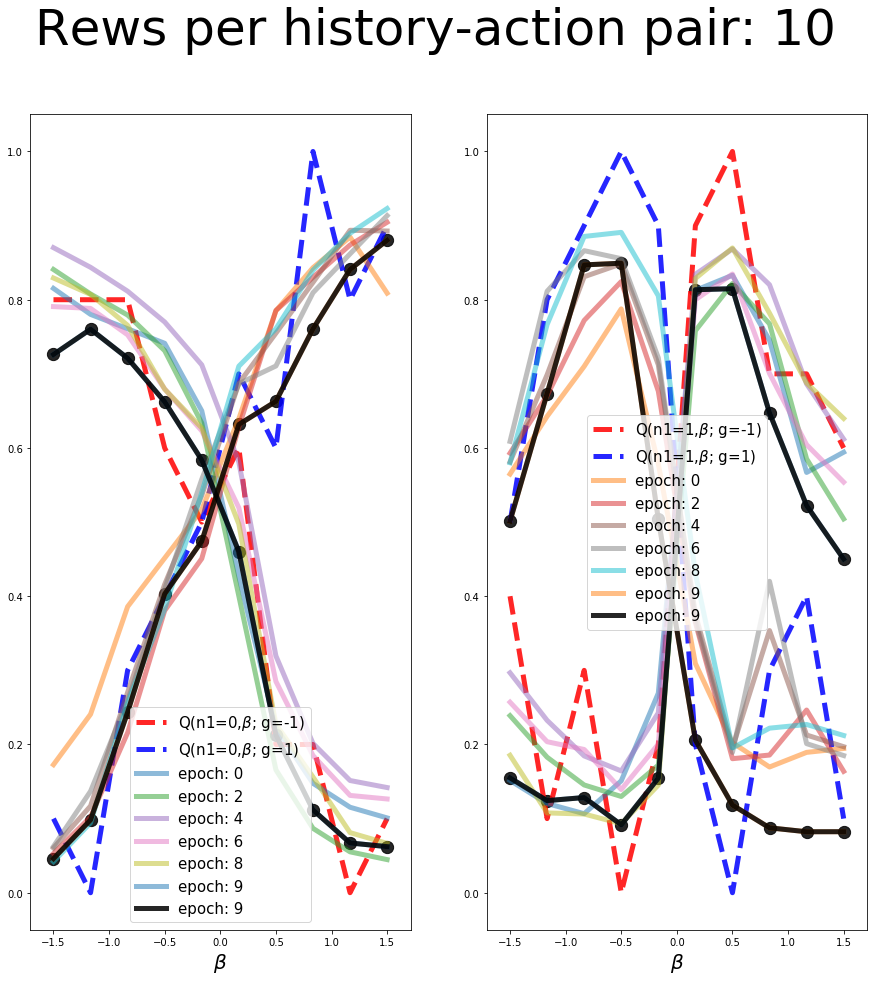

In [179]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10, batch_size=1.,seed_val=0.01,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-4, retraining=True,printing_losses=False,
                                                                    optimizer_object=optimizer,net_object=net
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

## NOW TAKE BATCH 2.##

Seed_val: 0.01
Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 2.0
epochs: 50
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 2)
Epoch 000: Loss: 0.2499902
Epoch 005: Loss: 0.2459362
Epoch 010: Loss: 0.2431954
Epoch 015: Loss: 0.2434322
Epoch 020: Loss: 0.2393410
Epoch 025: Loss: 0.2382567
Epoch 030: Loss: 0.2327661
Epoch 035: Loss: 0.2319658
Epoch 040: Loss: 0.2354922
Epoch 045: Loss: 0.2267025
Tardé:  0:01:50.660202


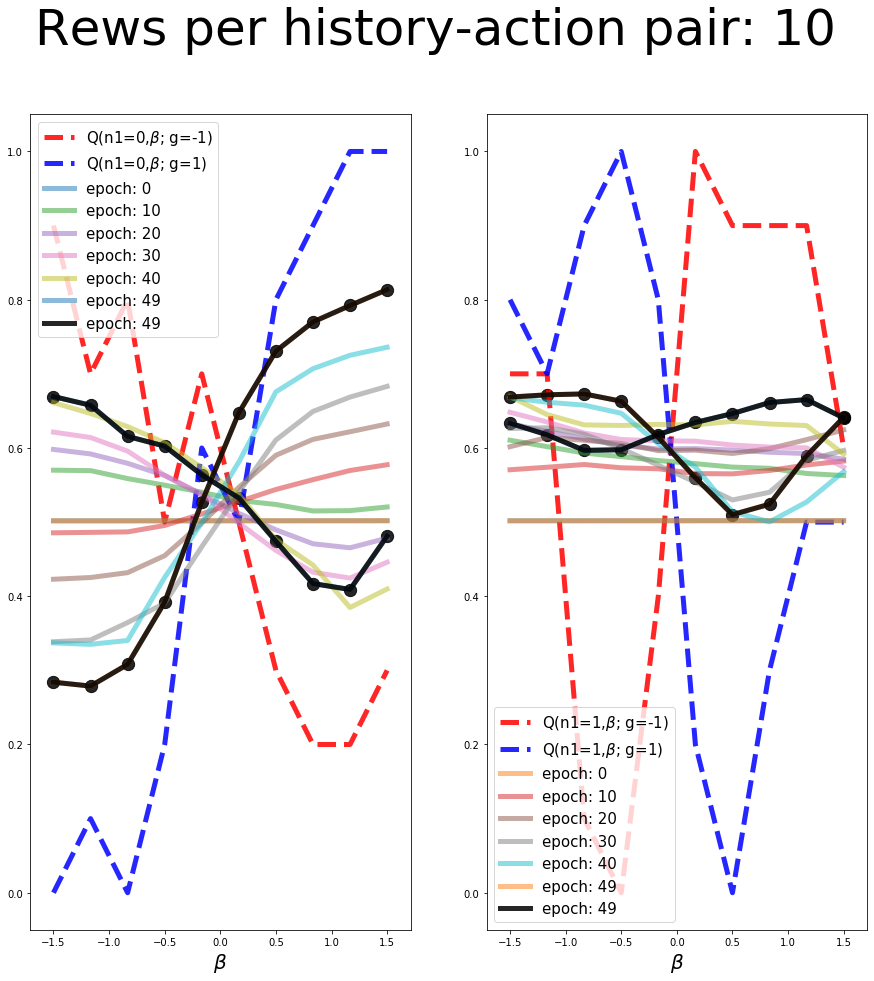

In [180]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=50, batch_size=2.,seed_val=0.01,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-4, retraining=False,printing_losses=False,
                                                                    optimizer_object=optimizer,net_object=net
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

## Now i try with batch = epoch ##

Seed_val: 0.01
Optimizer: Adam
Real number of splits (len(dataset) after spliting): 400
len(data[0]: 4
Batch size: 400
epochs: 4000
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400
Shuffling in each epoch
Regularizer value: True
Dropout rate (first and second layer): 0.05: 



len(data[0]: 400)
Epoch 000: Loss: 0.2500361
Epoch 400: Loss: 0.2499438
Epoch 800: Loss: 0.2499438
Epoch 1200: Loss: 0.2499438
Epoch 1600: Loss: 0.2499438
Epoch 2000: Loss: 0.2499438
Epoch 2400: Loss: 0.2499438
Epoch 2800: Loss: 0.2499438
Epoch 3200: Loss: 0.2499438
Epoch 3600: Loss: 0.2499438
Tardé:  0:02:32.229106


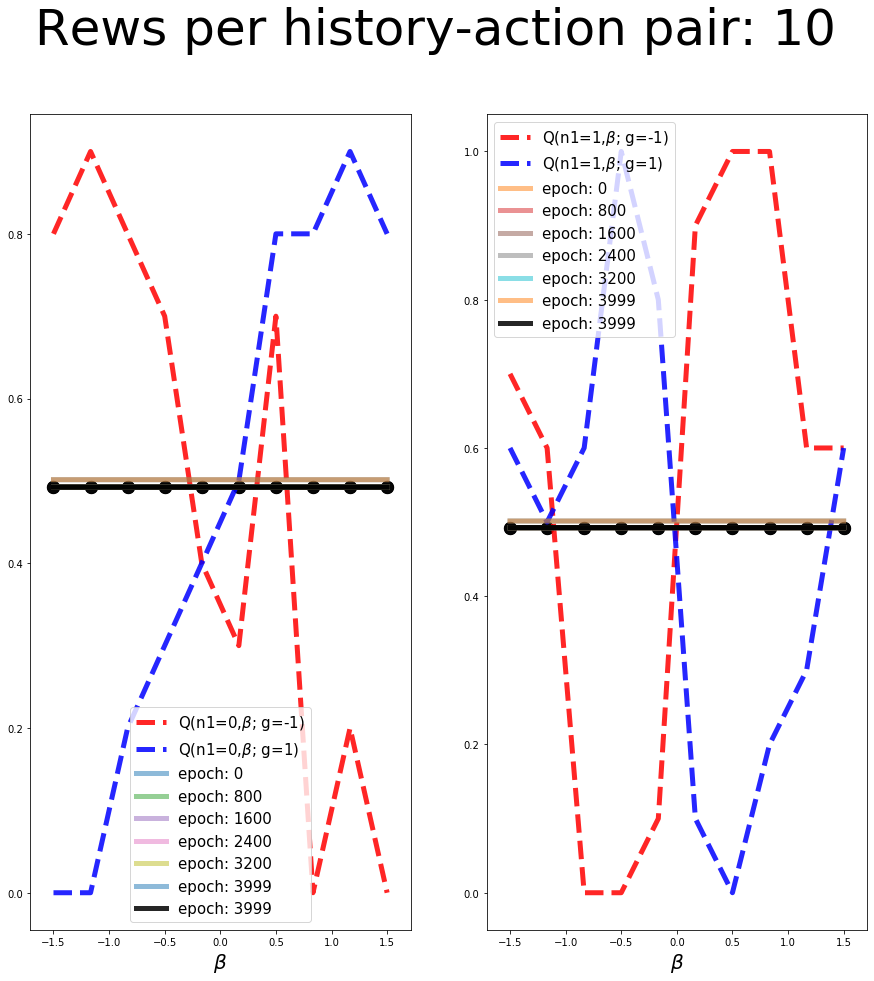

In [191]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10*4*10*10, batch_size=10*4*10,seed_val=0.01,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.05, dropout=0.01, optimizer_name="Adam", lr=10**-3, retraining=False,printing_losses=False,
                                                                    optimizer_object=optimizer,net_object=net
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

** so it apperars to stuck at the mean value of the sum of all rewards, which is not what we want **

In [ ]:
histo_preds, mean_values, net, optimizer, losses = learning_problem(10,epochs=10*4*10*10, batch_size=10*4*10,seed_val=0.01,
                                               number_of_betas=10, shuffling_in_each_epoch=True, valreg=0.005, dropout=0.001, optimizer_name="Adam", lr=10**-2, retraining=False,printing_losses=False,
                                                                    optimizer_object=optimizer,net_object=net
                                                                   ) 
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")